In [38]:
import cv2
import numpy as np 
import pandas as pd 
import os
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import datasets, layers, models, losses, Model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pre
from sklearn.metrics import f1_score
from copy import copy
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [42]:
Train_img_list=pd.read_csv('../../data/preprocessing_dataset/Train_data_set.csv')['file_path'].to_list()
Train_label_list=pd.read_csv('../../data/preprocessing_dataset/Train_data_set.csv')['standard_frame'].to_list()
Test_img_list=pd.read_csv('../../data/preprocessing_dataset/Test_data_set.csv')['file_path'].to_list()
Test_label_list=pd.read_csv('../../data/preprocessing_dataset/Test_data_set.csv')['standard_frame'].to_list()

In [39]:
Train_img_list=pd.read_csv('../../data/original_dataset/Train_data_set.csv')['file_path'].to_list()
Train_label_list=pd.read_csv('../../data/original_dataset/Train_data_set.csv')['standard_frame'].to_list()
Test_img_list=pd.read_csv('../../data/original_dataset/Test_data_set.csv')['file_path'].to_list()
Test_label_list=pd.read_csv('../../data/original_dataset/Test_data_set.csv')['standard_frame'].to_list()

In [40]:
size=256
origin_x_test = np.zeros((len(Test_img_list),size,size,3))
origin_y_test = np.zeros((len(Test_label_list),1))
for i in range(len(Test_img_list)):
    origin_x_test[i] =np.array(Image.open('../../data/original_dataset/'+Test_img_list[i]).resize((size,size)))
x_test=origin_x_test/255
y_test=np.array(Test_label_list)
x_test,x_val,y_test,t_val=train_test_split(x_test,y_test,test_size=0.5,random_state=42)

In [43]:
size=256
preprocess_x_test = np.zeros((len(Test_img_list),size,size,3))
preprocess_y_test = np.zeros((len(Test_label_list),1))
for i in range(len(Test_img_list)):
    preprocess_x_test[i] =np.array(Image.open('../../data/preprocessing_dataset/'+Test_img_list[i]).resize((size,size)))
x_test=preprocess_x_test/255
y_test=np.array(Test_label_list)
x_test,x_val,y_test,t_val=train_test_split(x_test,y_test,test_size=0.5,random_state=42)

32/32 [==============================] - 2s 22ms/step
Threshholds= 0.449


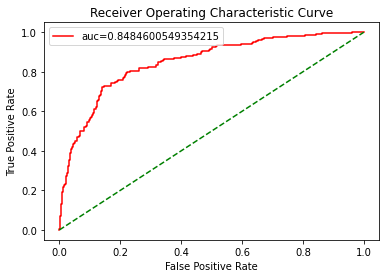

                  precision    recall  f1-score   support

NotStandardFrame       0.91      0.86      0.88       781
   StandardFrame       0.61      0.72      0.66       241

        accuracy                           0.83      1022
       macro avg       0.76      0.79      0.77      1022
    weighted avg       0.84      0.83      0.83      1022



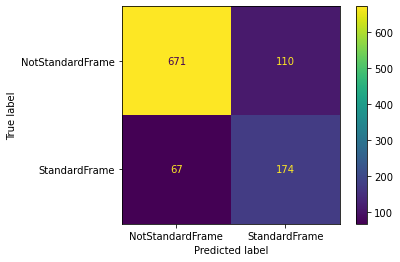

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
def plot_roc_curve(fper, tper):
    
    plt.plot(fper, tper, color='red', label='auc='+str(auc_score))
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

model = K.models.load_model('../../model/resnet50_preprocessing_checkpoints.h5')
classes = ['NotStandardFrame','StandardFrame']
prob =model.predict(x_test)

a=np.linspace(0.000,1.000,1001)
report1=0
tresh_hold=0.000
for i in a:
    t_prob=np.where(prob>i,1,0)
    report = f1_score(y_test, t_prob)
    if report1<=report:
        tresh_hold=copy(i)
        report1=copy(report)
print(f"Threshholds= {tresh_hold}")
fper, tper, thresholds = roc_curve(y_test, prob)
auc_score=roc_auc_score(y_test, prob)
plot_roc_curve(fper, tper)
t_prob=np.where(prob>tresh_hold,1,0)
report = classification_report(y_test, t_prob, target_names=classes)
cm = confusion_matrix(y_test, t_prob)
cm_display = ConfusionMatrixDisplay(cm,
                              display_labels=classes).plot()

print(report)

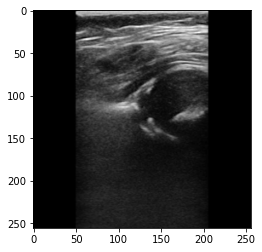

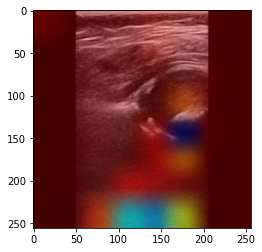

In [46]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import resnet50, ResNet50
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
resnet = model.get_layer('resnet50')
last_conv_layer=resnet.get_layer('conv5_block3_out')
model_1= keras.Model(resnet.inputs, last_conv_layer.output)
input_2 = keras.Input(shape=last_conv_layer.output.shape[1:])
x_2 = resnet.get_layer("avg_pool")(input_2)
x_2 = resnet.get_layer("predictions")(x_2)
model_2=keras.Model(input_2,x_2)

for image_index in np.where(y_test==1)[0]:
    with tf.GradientTape() as tape:
        output_1 = model_1(x_test[image_index:image_index+1])
        tape.watch(output_1) #마지막 층으로 미분하기 위한 준비
        preds = model_2(output_1)
        class_id = tf.argmax(preds[0])
        output_2 = preds[:,class_id]

    grads = tape.gradient(output_2, output_1) #그레디언트 계산
    pooled_grads = tf.reduce_mean(grads,axis=(0,1,2)) #식5 적용

    output_1 = output_1.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        output_1[:,:,i]*=pooled_grads[i]
    heatmap=np.mean(output_1, axis=-1)

    heatmap =np.maximum(heatmap, 0)/np.max(heatmap) #정규화

    #열지도를 입력 영상에 씌움
    img =x_test[image_index]
    heatmap=np.uint8(255*heatmap) # [0,255]로 변환

    jet = cm.get_cmap("jet") #jet 컬러맵으로 표시
    color = jet(np.arange(256))[:,:3]
    color_heatmap = color[heatmap]

    color_heatmap = keras.preprocessing.image.array_to_img(color_heatmap)
    color_heatmap = color_heatmap.resize((img.shape[1], img.shape[0]))
    color_heatmap = keras.preprocessing.image.img_to_array(color_heatmap)

    overlay_img= color_heatmap*0.0025+img #덧씌움
    overlay_img = (overlay_img/overlay_img.max()*255).astype(np.uint8)  # 이미지의 픽셀 깊이를 8비트로 변환
    overlay_img = cv2.cvtColor(overlay_img, cv2.COLOR_RGB2BGR) 
    img = (img/img.max()*255).astype(np.uint8)
    img=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    cv2.imwrite('../../data/heatmap/img/'+str(image_index)+'.jpg',img)
    cv2.imwrite('../../data/heatmap/heat/'+str(image_index)+'.jpg',overlay_img)
plt.imshow(img)
plt.show()
plt.imshow(overlay_img)